In [1]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(data.table))


# Sample codes for Mendelian Randomization

## 2020/3/11 Yosuke Tanigawa

In the problem set, we asked you to perform MR using the following methods:

1. variant-specific causal estimate (ratio metho)
2. Inverse-variance weighted method (IVW)
3. Median estimation
4. Modal estimation
5. Multivariate method
6. MR-Base Web app.

This notebook contains example codes for methods 1-5.


## data-preprocessing

### read the set of LD independent variants

In [2]:
extract_file <- 'data/LD_indep.lst.gz'

extract_list <- fread(cmd=paste('zcat', extract_file), head=F) %>%
select(V1) %>%
pull()


### read the raw data (the full summary statistics from the Neale lab)

In [3]:
raw <- list()
raw[['MI']] <- fread(cmd=paste('zcat', 'data/I9_MI.gwas.imputed_v3.both_sexes.tsv.bgz'))
raw[['HDL']] <- fread(cmd=paste('zcat', 'data/30760_irnt.gwas.imputed_v3.both_sexes.tsv.bgz'))
raw[['LDL']] <- fread(cmd=paste('zcat', 'data/30780_irnt.gwas.imputed_v3.both_sexes.tsv.bgz'))


In [4]:
for(trait in names(raw)){
    print(trait)
    raw[[trait]]%>% dim() %>% print()
}


[1] "MI"
[1] 13791467       12
[1] "HDL"
[1] 13791467       11
[1] "LDL"
[1] 13791467       11


### filter by LD independence

In [5]:
ld_indep <- list()
for(trait in names(raw)){
    ld_indep[[trait]] <- raw[[trait]] %>%
    filter(
        variant %in% extract_list
    ) %>% 
    select(
        variant, low_confidence_variant, beta, se, pval
    )
}


In [6]:
for(trait in names(ld_indep)){
    print(trait)
    ld_indep[[trait]]%>% dim() %>% print()
}


[1] "MI"
[1] 1107248       5
[1] "HDL"
[1] 1107248       5
[1] "LDL"
[1] 1107248       5


### filter by p-value on the exposure phenotype and join with the BETAs of MI

In [7]:
dfs <- list()
for(trait in c('HDL', 'LDL')){
    dfs[[paste(trait, 'MI', sep='_')]] <- ld_indep[[trait]] %>%
    drop_na(pval) %>%
    filter(pval < 5e-8) %>%
    left_join(
        ld_indep[['MI']], by='variant'
    ) %>%
    drop_na(beta.x, beta.y) %>%
    mutate(
        ratio = beta.y / beta.x
    )
}

In [8]:
for(traits in names(dfs)){
    print(traits)
    dfs[[traits]]%>% dim() %>% print()
}


[1] "HDL_MI"
[1] 3325   10
[1] "LDL_MI"
[1] 1897   10


### visualize the data

In [9]:
plot_beta_vs_beta <- function(df, trait_x, trait_y){
    lmfit <- lm(beta.y ~ 0 + beta.x, df)
    print(sprintf('%s --> %s', trait_x, trait_y))
    print(lmfit)
    df %>%
    ggplot(aes(x = beta.x, y = beta.y)) + 
    geom_abline(
        slope = (lmfit)$coefficients[['beta.x']],
        color='red', alpha=.5
    ) + 
    geom_point(alpha=.1) +
    theme_bw() +
    labs(
        x = sprintf('BETA (%s)', trait_x),
        y = sprintf('BETA (%s)', trait_y)    
    )
}

In [10]:
library(repr)
library(gridExtra)


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



[1] "HDL --> MI"

Call:
lm(formula = beta.y ~ 0 + beta.x, data = df)

Coefficients:
   beta.x  
-0.005781  

[1] "LDL --> MI"

Call:
lm(formula = beta.y ~ 0 + beta.x, data = df)

Coefficients:
 beta.x  
0.01091  



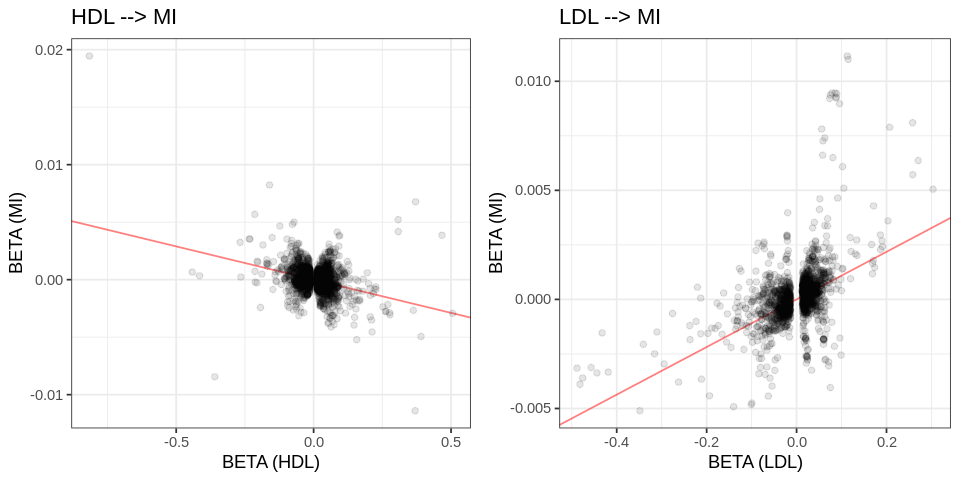

In [11]:
options(repr.plot.width=8, repr.plot.height=4)
grid.arrange(
    dfs[['HDL_MI']] %>% 
    plot_beta_vs_beta('HDL', 'MI') +
    labs(title='HDL --> MI'),
    
    dfs[['LDL_MI']] %>% 
    plot_beta_vs_beta('LDL', 'MI') +
    labs(title='LDL --> MI'),
    
    ncol=2
)

## i) variant-specific causal estimate

In [12]:
plot_ratio_estimate <- function(df){
    df %>%
    ggplot(aes(x = ratio)) + 
    geom_histogram(bins=30, fill='gray', color='gray') + 
    geom_vline(xintercept = median(df$ratio), color='red') + 
    annotate(
        "text", x = median(df$ratio), y = 20, 
        label = sprintf('median = %.4f', median(df$ratio))
    ) + 
    theme_bw() + 
    labs(
        x = 'ratio estimate'
    )    
}

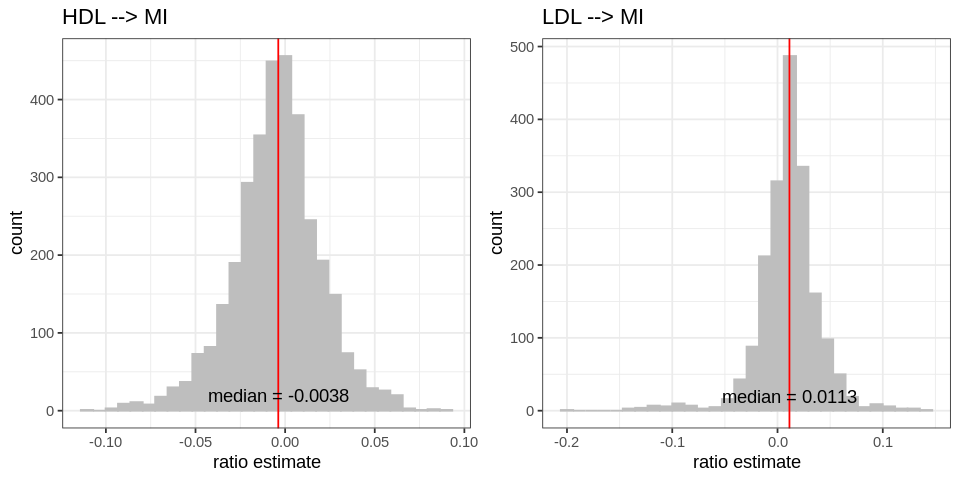

In [13]:
options(repr.plot.width=8, repr.plot.height=4)
grid.arrange(
    dfs[['HDL_MI']] %>% 
    plot_ratio_estimate +
    labs(title='HDL --> MI'),
    
    dfs[['LDL_MI']] %>% 
    plot_ratio_estimate +
    labs(title='LDL --> MI'),
    
    ncol=2
)

In [14]:
summary(dfs[['HDL_MI']]$ratio)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.110831 -0.018787 -0.003824 -0.004622  0.009613  0.089507 

In [15]:
summary(dfs[['LDL_MI']]$ratio)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.200943 -0.002871  0.011331  0.010245  0.024068  0.140175 

## ii) Inverse-variance weighted method (IVW)

In [16]:
compute_IVW_estimate <- function(df){
    sum(df$ratio * ((df$se.y) ** -2)) / sum((df$se.y) ** -2)
}

In [17]:
dfs[['HDL_MI']]  %>%
compute_IVW_estimate()

[1] -0.004922881

In [18]:
dfs[['LDL_MI']]  %>%
compute_IVW_estimate()

[1] 0.01005267

## iii) Median estimation

In [19]:
median(dfs[['HDL_MI']]$ratio)

[1] -0.003824299

In [20]:
median(dfs[['LDL_MI']]$ratio)

[1] 0.0113315

## iii) Modal estimation

In [21]:
plot_modal_estimate <- function(df){
    kdefit <- ks::kde(x = df$ratio)    
    mbe <- kdefit$eval.points[which.max(predict(kdefit, x=kdefit$eval.points))]
    
    data.frame(
        x = kdefit$eval.points,
        y = predict(kdefit, x=kdefit$eval.points)
    ) %>%
    ggplot(aes(x = x, y = y)) +
    geom_line() +
    geom_vline(xintercept = mbe, color='red') + 
    annotate(
        "text", x = mbe, y = -1, 
        label = sprintf('Modal estimate = %.6f', mbe)
    ) + 
    theme_bw() + 
    labs(
        x = 'ratio estimate',
        y = 'Kernel density estimate'
    )    
}

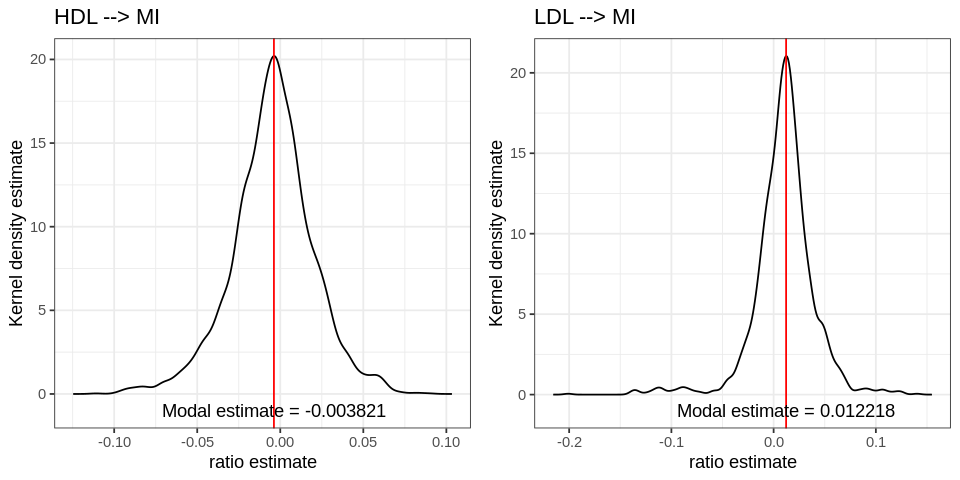

In [22]:
options(repr.plot.width=8, repr.plot.height=4)
grid.arrange(
    dfs[['HDL_MI']] %>% 
    plot_modal_estimate() +
    labs(title='HDL --> MI'),
    
    dfs[['LDL_MI']] %>% 
    plot_modal_estimate() +
    labs(title='LDL --> MI'),
    
    ncol=2
)

## iv) Multivariate

In [23]:
length(union(dfs[['LDL_MI']]$variant, dfs[['HDL_MI']]$variant))

[1] 4964

In [24]:
multi_df <- dfs[['LDL_MI']] %>% 
select(variant, beta.x, beta.y, se.y) %>%
rename('beta.LDL' = 'beta.x') %>%
full_join(
    dfs[['HDL_MI']] %>%
    select(variant, beta.x, beta.y, se.y) %>%
    rename('beta.HDL' = 'beta.x'),
    by=c('variant', 'beta.y', 'se.y')
) %>%
rename('beta.MI' = 'beta.y', 'se.MI' = 'se.y') %>% 
replace_na(list(beta.LDL = 0, beta.HDL = 0))


In [25]:
multi_df %>% dim()

[1] 4964    5

In [26]:
multi_lm <- lm(
    beta.MI ~ 0 + beta.LDL + beta.HDL, 
    data = multi_df
)


In [27]:
multi_lm


Call:
lm(formula = beta.MI ~ 0 + beta.LDL + beta.HDL, data = multi_df)

Coefficients:
 beta.LDL   beta.HDL  
 0.010666  -0.005445  


In [28]:
summary(multi_lm)


Call:
lm(formula = beta.MI ~ 0 + beta.LDL + beta.HDL, data = multi_df)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0104004 -0.0003314  0.0000736  0.0004883  0.0150079 

Coefficients:
           Estimate Std. Error t value Pr(>|t|)    
beta.LDL  0.0106659  0.0003943   27.05   <2e-16 ***
beta.HDL -0.0054452  0.0003295  -16.52   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.001035 on 4962 degrees of freedom
Multiple R-squared:  0.1733,	Adjusted R-squared:  0.173 
F-statistic:   520 on 2 and 4962 DF,  p-value: < 2.2e-16


In [29]:
multi_weighted_lm <- lm(
    beta.MI ~ 0 + beta.LDL + beta.HDL, 
    weights = (multi_df$se.MI) ** (-2),
    data = multi_df
)

In [30]:
multi_weighted_lm


Call:
lm(formula = beta.MI ~ 0 + beta.LDL + beta.HDL, data = multi_df, 
    weights = (multi_df$se.MI)^(-2))

Coefficients:
 beta.LDL   beta.HDL  
 0.009737  -0.004395  


In [31]:
summary(multi_weighted_lm)


Call:
lm(formula = beta.MI ~ 0 + beta.LDL + beta.HDL, data = multi_df, 
    weights = (multi_df$se.MI)^(-2))

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-7.6086 -0.6269  0.1333  0.9395 12.9211 

Coefficients:
           Estimate Std. Error t value Pr(>|t|)    
beta.LDL  0.0097374  0.0003935   24.74   <2e-16 ***
beta.HDL -0.0043947  0.0003374  -13.03   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.379 on 4962 degrees of freedom
Multiple R-squared:  0.142,	Adjusted R-squared:  0.1417 
F-statistic: 410.6 on 2 and 4962 DF,  p-value: < 2.2e-16


## v) MR-Base

### reformat the data

In [32]:
variant_info <- fread(
    cmd=paste('zcat', 'data/variants.tsv.bgz'), 
    select = c('variant', 'rsid')
) %>%
filter(
    variant %in% extract_list
)


In [33]:
MR_Base <- list()
for(trait in names(raw)){
    MR_Base[[trait]] <- raw[[trait]] %>%    
    inner_join(
        variant_info %>%
        filter(variant %in% (multi_df %>% select(variant) %>% pull())), 
        by='variant'
    ) %>%
    mutate(
        variant_copy = variant
    ) %>%
    separate(
        variant_copy, 
        c('CHROM', 'POS', 'other_allele', 'effect_allele')
    ) %>%
    mutate(
        Phenotype = trait,
        ALT_eq_minor = (minor_allele == effect_allele),
        eaf = if_else(ALT_eq_minor, minor_AF, 1 - minor_AF)
    ) %>%
    rename('SNP' = 'rsid', 'samplesize' = 'n_complete_samples') %>%
    select(Phenotype, SNP, effect_allele, other_allele, beta, se, eaf, samplesize, variant, pval)    
}


In [34]:
for(trait in c('HDL', 'LDL')){
    MR_Base[[trait]] %>% 
    filter(pval < 5e-8) %>%
    arrange(pval) %>%
    head(1000) %>%
    fwrite(file.path('data', sprintf('MR_Base.pval.%s.txt', trait)), sep='\t')
}


In [35]:
# for(trait in names(MR_Base)){
#     MR_Base[[trait]] %>% 
#     fwrite(file.path('data', sprintf('MR_Base.full.%s.txt', trait)), sep='\t')
# }
